# Still need to bin industry better

# Step 0: Imports and loading data

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import seaborn as sns
from scipy.stats import zscore, skew
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from itertools import chain
import xgboost
from sklearn import metrics, model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.decomposition import PCA

from sklearn.metrics import roc_curve, confusion_matrix

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', 500)

In [77]:
raw_data = pd.read_excel('Competition1_raw_data.xlsx')
data = raw_data.copy()

In [78]:
data.head()

,I1,I2,I3,P(IPO),P(H),P(L),P(1Day),C1,C2,C3,C4,C5,C6,C7,T1,T2,T3,T4,T5,S1,S2,S3
0,AATI,ADVANCED ANALOGIC TECHNOLOGIES INC,3674,10,9.5,8.5,11.87,122,1,3.43,0.0290743,40962052,10600000,51.345,470,12719,11560,301,690,62,117,139
1,ABPI,ACCENTIA BIOPHARMACEUTICALS INC,2834,8,10,8,7.25,259,0,-1.62,-0.0133516,28869196,2400000,25.936,791,21792,19585,510,1120,71,242,237
2,ACAD,ACADIA PHARMACEUTICALS INC,2834,7,14,12,6.7,90,1,-1.24,0.020715,16845668,5000000,7.378,201,5262,4785,128,325,61,33,60
3,ACHN,ACHILLION PHARMACEUTICALS INC,2834,11.5,16,14,12.39,209,1,-0.91,0.0200231,14848637,4500000,8.526,328,8259,7574,177,509,80,59,110
4,ACLI,AMERICAN COMMERCIAL LINES INC.,4492,21,21,19,56.6,80,1,0.07,-0.0348947,30741716,8250000,632.298,572,14830,13176,336,720,67,149,167


# Step 1: Identify the null values

As given, the data identifies some null values with the '-' symbol. Replacing these with actual null values will allow handling them to be easier.

In [79]:
for col in data.columns:
    data[col] = data[col].apply(lambda x: np.nan if x == '-' else x)

In [80]:
def data_validation(row):  
    '''
    Run initially to identify rows which do not logically make sense.
    Fix the issues, and then rerun until only nulls left
    
    '''
    # If any nulls we know it's off
    ret_val = 0
    if row.isna().any():
        ret_val = 1
    
    # P(H) > P(L)
    #Higher range of price > lower range
    if row['P(H)'] < row['P(L)']:
        ret_val = 2
    
    # T4 < T1
    # Number of long sentences less than number of sentences
    elif row['T4'] > row['T1']:
        ret_val = 3
        
    # T3 < T2
    # Number of words < number of real words
    elif row['T3'] > row['T2']:
        ret_val = 4
        
    # T5 < T2
    # Number of long words < number of total words
    elif row['T5'] > row['T2']:
        ret_val = 5
        
    # T1 < T2
    # Number of words > number of sentences
    elif row['T1'] > row['T2']:
        ret_val = 6
    
    # C2, C3' in [0,1]
    # Defined as only being one of these two
    elif row['C2'] not in [0.0,1.0] and pd.notnull(row['C2']):
        ret_val = 7
    
    return ret_val
    

In [81]:
data['data_updated'] = data.apply(lambda row: data_validation(row), axis = 1)

In [82]:
data.data_updated.value_counts()

0    590
1     87
4      2
2      2
3      1
Name: data_updated, dtype: int64

We can see that there are 87 rows containing null values. Additionally, a few rows contain logic which does not make sense. We can fix those now, rerun, and check that all rows do not have logical flaws. 

In [83]:
data.loc[data['data_updated'] == 2, ['P(H)','P(L)']] = np.nan

In [84]:
data.loc[data['data_updated'] == 3, ['T4','T1']] = np.nan

In [85]:
data.loc[data['data_updated'] == 4, ['T3','T2']] = np.nan

In [86]:
data['data_updated'] = data.apply(lambda row: data_validation(row), axis = 1)

In [87]:
data.data_updated.value_counts()

0    590
1     91
4      1
Name: data_updated, dtype: int64

A single row had more than one logical issue. We can fix this, and run or identification function again to ensure all rows have been cleaned.

In [88]:
data.loc[data['data_updated'] == 4, ['T3','T2']] = np.nan

In [89]:
data['data_updated'] = data.apply(lambda row: data_validation(row), axis = 1)

In [90]:
data.data_updated.value_counts()

0    590
1     92
Name: data_updated, dtype: int64

Now the only issue left is the null values which we can address through imputation

# Step 2: Descriptive Statistics
- Mean/median/std/min/max/count/quartiles
- Missing Records
- Outlier Identification
    - Address Outliers
- Data Types/Fix data types

The describe method can give a lot of useful information about each of the column values including quartile information, the mean, minimum and maximum values, and the standard deviation.

In [91]:
data.describe()

,P(IPO),P(H),P(L),P(1Day),C1,C2,C3,C4,C5,C6,C7,T1,T2,T3,T4,T5,S1,S2,S3,data_updated
count,677.000000,670.000000,670.000000,660.000000,660.000000,660.000000,646.000000,660.000000,6.760000e+02,6.760000e+02,610.000000,680.000000,678.000000,678.000000,680.000000,681.000000,681.000000,681.000000,681.000000,682.000000
mean,13.837666,15.522925,13.527030,25.934766,149.728788,0.859091,1.788904,0.007282,4.935776e+07,1.241519e+07,500.459962,465.957353,12814.283186,11377.873156,294.264706,679.220264,68.421439,120.104258,144.759178,0.134897
std,6.053731,6.618732,5.839649,73.234948,152.817467,0.348192,162.666532,0.033318,1.043764e+08,2.512855e+07,1648.337634,175.668619,5396.780570,4833.321230,121.599795,472.914323,39.096525,84.828959,69.276285,0.341865
min,3.000000,4.000000,3.000000,0.000000,10.000000,0.000000,-786.239000,-0.162352,3.693227e+06,5.250000e+05,0.074000,132.000000,3271.000000,0.000000,0.000000,-1.000000,-1.000000,20.000000,26.000000,0.000000
25%,10.000000,13.000000,11.000000,11.000000,85.000000,1.000000,-0.852500,-0.013927,1.871417e+07,5.000000e+06,37.245750,351.750000,9213.250000,8135.000000,212.750000,462.000000,45.000000,73.000000,100.000000,0.000000
50%,13.500000,15.000000,13.000000,14.845000,107.000000,1.000000,0.010000,0.009125,2.740018e+07,7.398704e+06,103.833000,444.500000,12056.000000,10774.500000,279.000000,624.000000,60.000000,100.000000,134.000000,0.000000
75%,17.000000,17.000000,15.000000,20.485000,155.250000,1.000000,0.470000,0.031571,4.980786e+07,1.200000e+07,331.138000,551.250000,15243.250000,13712.000000,353.250000,795.000000,85.000000,142.000000,173.000000,0.000000
max,85.000000,135.000000,108.000000,1159.200562,2087.000000,1.000000,3864.500000,0.092896,2.138085e+09,4.212336e+08,30683.000000,1750.000000,49056.000000,43952.000000,1058.000000,10277.000000,309.000000,944.000000,883.000000,1.000000


A count of the null values in each column can also be compiled.

In [92]:
pd.isna(data).sum()

I1               0
I2               0
I3               8
P(IPO)           5
P(H)            12
P(L)            12
P(1Day)         22
C1              22
C2              22
C3              36
C4              22
C5               6
C6               6
C7              72
T1               2
T2               4
T3               4
T4               2
T5               1
S1               1
S2               1
S3               1
data_updated     0
dtype: int64

The data types will also give more information. We expect most to be numeric, either float or ints, with the exception of the first two columns.

In [93]:
data.dtypes

I1               object
I2               object
I3               object
P(IPO)          float64
P(H)            float64
P(L)            float64
P(1Day)         float64
C1              float64
C2              float64
C3              float64
C4              float64
C5              float64
C6              float64
C7              float64
T1              float64
T2              float64
T3              float64
T4              float64
T5              float64
S1              float64
S2              float64
S3              float64
data_updated      int64
dtype: object

Strangely, the data type of I3 appears to be object. In taking a closer look we can see several rows have a string representation of a lists of integers rather than a single integer. 

In [94]:
data[data.I3.apply(lambda x: isinstance(x, str))]

,I1,I2,I3,P(IPO),P(H),P(L),P(1Day),C1,C2,C3,C4,C5,C6,C7,T1,T2,T3,T4,T5,S1,S2,S3,data_updated
174,DLB,"Dolby Laboratories, Inc.","6794, 3861, 3663, 7819",18.0,18.0,16.0,24.299999,90.0,1.0,0.47,0.020090,97362135.0,27500000.0,289.041,500.0,15288.0,14243.0,360.0,912.0,69.0,122.0,165.0,0
187,DTSI,"DTS, INC.","3651, 6794, 7819",17.0,16.0,14.0,24.920000,76.0,0.0,0.99,0.044011,13097313.0,3840000.0,41.056,339.0,8274.0,7487.0,204.0,421.0,49.0,95.0,70.0,0
499,RLD,RealD Inc.,"3663, 3861, 6794",16.0,15.0,13.0,19.510000,98.0,1.0,-0.33,0.012058,47638374.0,12500000.0,39.675,629.0,15904.0,14741.0,364.0,899.0,104.0,139.0,227.0,0
620,UPG,UNIVERSAL POWER GROUP,"7389, 5063",7.0,9.0,7.0,7.350000,101.0,0.0,0.38,-0.000171,5000000.0,3000000.0,81.275,304.0,6904.0,6234.0,147.0,287.0,29.0,61.0,66.0,0


The column I3 refers to the SIC code value associated with a company. As these companies have more than one we can use the following chart to see if any of the rows with more than one SIC code have a natural grouping in their values. 

<table class="wikitable sortable jquery-tablesorter">

<thead><tr>
<th class="headerSort" tabindex="0" role="columnheader button" title="Sort ascending">Range of SIC Codes
</th>
<th class="headerSort" tabindex="0" role="columnheader button" title="Sort ascending">Division
</th></tr></thead><tbody>
<tr>
<td>0100-0999
</td>
<td>Agriculture, Forestry and Fishing
</td></tr>
<tr>
<td>1000-1499
</td>
<td>Mining
</td></tr>
<tr>
<td>1500-1799
</td>
<td>Construction
</td></tr>
<tr>
<td>1800-1999
</td>
<td>not used
</td></tr>
<tr>
<td>2000-3999
</td>
<td>Manufacturing
</td></tr>
<tr>
<td>4000-4999
</td>
<td>Transportation, Communications, Electric, Gas and Sanitary service
</td></tr>
<tr>
<td>5000-5199
</td>
<td>Wholesale Trade
</td></tr>
<tr>
<td>5200-5999
</td>
<td>Retail Trade
</td></tr>
<tr>
<td>6000-6799
</td>
<td>Finance, Insurance and Real Estate
</td></tr>
<tr>
<td>7000-8999
</td>
<td>Services
</td></tr>
<tr>
<td>9100-9729
</td>
<td>Public Administration
</td></tr>
<tr>
<td>9900-9999
</td>
<td>Nonclassifiable
</td></tr></tbody><tfoot></tfoot></table>

Both Dolby Laboratories Inc. and RealD Inc. have some semblence of agreement in the SIC codes indicating mostly Manufacturing content. In order to represent this, these two rows will have their I3 column assigned to a value in the Manufacturing range.

The other two rows do not have the same SIC code overlap and will be set as a code in the "Nonclassifiable" range to avoid making assumptions.

In [95]:
# data.loc[174]['I3'] = 3500
# data.loc[499]['I3'] = 3500

# data.loc[187]['I3'] = 9999
# data.loc[620]['I3'] = 9999

data.loc[174, ['I3']] = 3500
data.loc[499, ['I3']] = 3500

data.loc[187, ['I3']] = 9999
data.loc[620, ['I3']] = 9999

We can now check again to be sure we no longer have string fields for this column.

In [96]:
data[data.I3.apply(lambda x: isinstance(x, str))]

,I1,I2,I3,P(IPO),P(H),P(L),P(1Day),C1,C2,C3,C4,C5,C6,C7,T1,T2,T3,T4,T5,S1,S2,S3,data_updated


Now that this has been handled, this field can be read as a a float64 field as originally intended and similar to the other fields.

In [97]:
data['I3'] = data['I3'].astype(np.float64)

In [98]:
data.dtypes

I1               object
I2               object
I3              float64
P(IPO)          float64
P(H)            float64
P(L)            float64
P(1Day)         float64
C1              float64
C2              float64
C3              float64
C4              float64
C5              float64
C6              float64
C7              float64
T1              float64
T2              float64
T3              float64
T4              float64
T5              float64
S1              float64
S2              float64
S3              float64
data_updated      int64
dtype: object

We can also leverage box plots to look at the distribution of the data.

In [99]:
data.head()

,I1,I2,I3,P(IPO),P(H),P(L),P(1Day),C1,C2,C3,C4,C5,C6,C7,T1,T2,T3,T4,T5,S1,S2,S3,data_updated
0,AATI,ADVANCED ANALOGIC TECHNOLOGIES INC,3674.0,10.0,9.5,8.5,11.870000,122.0,1.0,3.43,0.029074,40962052.0,10600000.0,51.345,470.0,12719.0,11560.0,301.0,690.0,62.0,117.0,139.0,0
1,ABPI,ACCENTIA BIOPHARMACEUTICALS INC,2834.0,8.0,10.0,8.0,7.250000,259.0,0.0,-1.62,-0.013352,28869196.0,2400000.0,25.936,791.0,21792.0,19585.0,510.0,1120.0,71.0,242.0,237.0,0
2,ACAD,ACADIA PHARMACEUTICALS INC,2834.0,7.0,14.0,12.0,6.700000,90.0,1.0,-1.24,0.020715,16845668.0,5000000.0,7.378,201.0,5262.0,4785.0,128.0,325.0,61.0,33.0,60.0,0
3,ACHN,ACHILLION PHARMACEUTICALS INC,2834.0,11.5,16.0,14.0,12.390000,209.0,1.0,-0.91,0.020023,14848637.0,4500000.0,8.526,328.0,8259.0,7574.0,177.0,509.0,80.0,59.0,110.0,0
4,ACLI,AMERICAN COMMERCIAL LINES INC.,4492.0,21.0,21.0,19.0,56.599998,80.0,1.0,0.07,-0.034895,30741716.0,8250000.0,632.298,572.0,14830.0,13176.0,336.0,720.0,67.0,149.0,167.0,0


Top level view of continuous fields with the exception of those used to create the target variables.

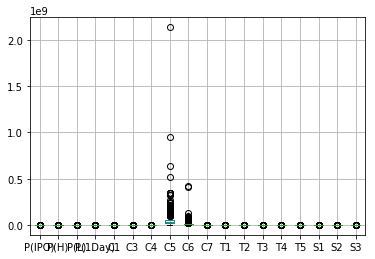

In [100]:
data[[i for i in data.columns if i not in ['I1','I2','I3', 'C2', 'data_updated']]].boxplot()
plt.show()

This is not very useful as the scale is dramatically different based on the column in question. In order to properly view each of these fields we will add a scaler to bring the data within the range of 0 and 1.

In [101]:
def min_max_scale_col(df, cols):
    scaler = preprocessing.MinMaxScaler()
    return scaler.fit_transform(df[cols])

def min_max_scale_df(df):
    scaler = preprocessing.MinMaxScaler()
    return scaler.fit_transform(df)

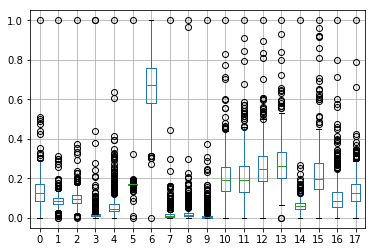

In [102]:
pd.DataFrame(min_max_scale_df(data[[i for i in data.columns if i not in ['I1','I2','I3', 'C2', 'data_updated']]])).boxplot()
plt.show()

It appears that there are many outliers which will need to be dealt with at a later point.

In [103]:
# for col in [i for i in data.columns if i not in ['I1','I2','I3']]:
#     data[[col]].boxplot()
#     plt.show()

In [104]:
# #Only plot numberical columns so drop non-numerical
# for col in data.drop(['I1','I2','I3'],axis=1).columns:
#     print("Column: ", col)
    
#     #Create Histograms
#     data[col].hist()
#     plt.xlabel(col)
#     plt.title('Histogram')
#     plt.show()
    
#     #Find outliers within 2 standard deviations of mean
#     outliers_low = (data[col].mean() - 3*data[col].std())
#     outliers_high = (data[col].mean() + 3*data[col].std())
    
#     #Print outlier values and counts of how many outliers
#     print("outliers low value <", outliers_low)
#     print("outlier low count: ", data[col][data[col] < outliers_low].count())
#     print("outliers high value >", outliers_high) 
#     print("outlier high count: ", data[col][data[col] > outliers_high].count())
#     print('\n')

# Step 3: Data Imputation
- Address null values dependent on the type of value in question
- Create a seperate column which shows whether or not imputation occurred

In [30]:
def impute_nulls_df(df, col, replace_val):
    '''
    params:
    
    df - dataframe containing nulls
    col - columns with nulls to replace
    replace_val - options: 'mean', 'median', 'mode'
    
    Example:

    imputed_data = impute_nulls(data, C1, 'mean')
    '''
    
    if replace_val not in ['mean','median','mode']:
        print('requires one of the following: mean, median, mode')
        return
    
    elif replace_val == 'mean':
        df[col + '_imputed'] = df[col].fillna(df[col].mean())
    elif replace_val == 'median':
        df[col + '_imputed'] = df[col].fillna(df[col].median())
    elif replace_val == 'mode':
        df[col + '_imputed'] = df[col].fillna(df[col].mode().values[0])
        
    return df

Create a dictionary for each value with the column and the type of imputation. Can then use a loop and the function above to impute them all.

Reminder of columns which need imputation

In [31]:
null_cols = pd.isna(data).sum()
null_cols = null_cols[null_cols.values != 0]
null_cols

I3          8
P(IPO)      5
P(H)       12
P(L)       12
P(1Day)    22
C1         22
C2         22
C3         36
C4         22
C5          6
C6          6
C7         72
T1          2
T2          4
T3          4
T4          2
T5          1
S1          1
S2          1
S3          1
dtype: int64

Fields leading with 'P' are needed for target, dropping these is acceptable

In [32]:
data = data[(~pd.isna(data['P(IPO)'])) & (~pd.isna(data['P(H)'])) & (~pd.isna(data['P(L)'])) & (~pd.isna(data['P(1Day)']))]

In [33]:
null_cols = pd.isna(data).sum()
null_cols = null_cols[null_cols.values != 0]
null_cols

C3    23
C7    60
T2     2
T3     2
dtype: int64

It appears that the items with null fields needed for the target variable constituted much of the null values across other columns. We only need to fix four now.

Look at histograms and review boxplots to get a better view of what to do for remaining null fields

/opt/tljh/user/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


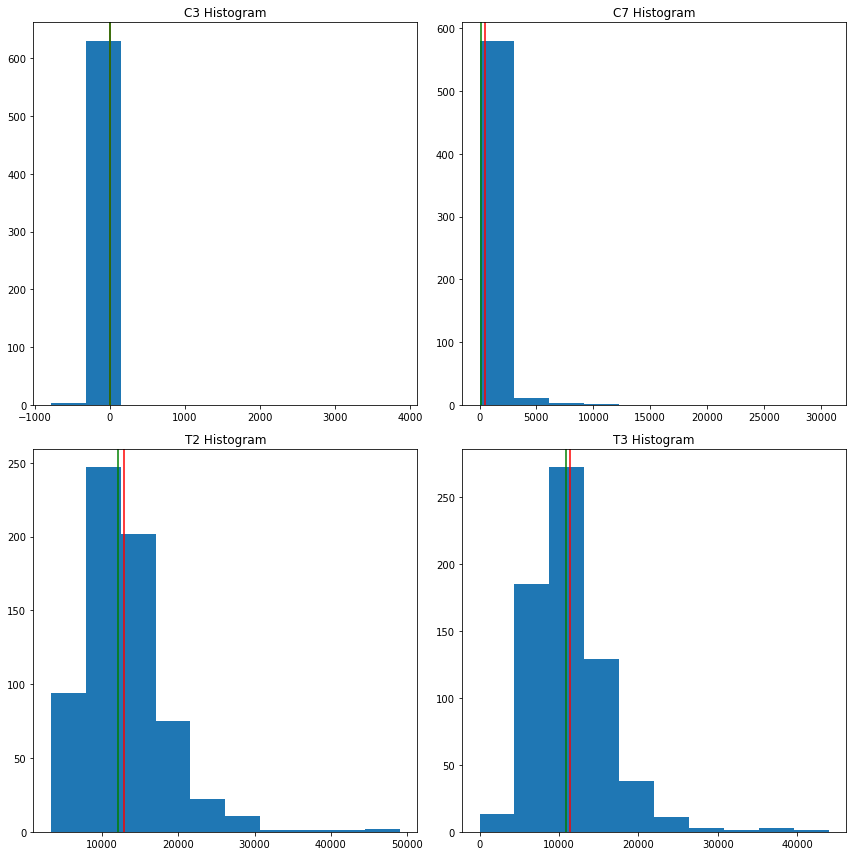

In [34]:
fig, axs = plt.subplots(2, 2, tight_layout=True, figsize=(12,12))

x1 = data['C3'].dropna()
x2 = data['C7'].dropna()
x3 = data['T2'].dropna()
x4 = data['T3'].dropna()

axs[0,0].hist(x1)
axs[0,0].axvline(x1.mean(), color = 'red')
axs[0,0].axvline(x1.median(), color = 'green')
axs[0,0].set_title('C3 Histogram')

axs[0,1].hist(x2)
axs[0,1].axvline(x2.mean(), color = 'red')
axs[0,1].axvline(x2.median(), color = 'green')
axs[0,1].set_title('C7 Histogram')

axs[1,0].hist(x3)
axs[1,0].axvline(x3.mean(), color = 'red')
axs[1,0].axvline(x3.median(), color = 'green')
axs[1,0].set_title('T2 Histogram')

axs[1,1].hist(x4)
axs[1,1].axvline(x4.mean(), color = 'red')
axs[1,1].axvline(x4.median(), color = 'green')
axs[1,1].set_title('T3 Histogram')

plt.show()

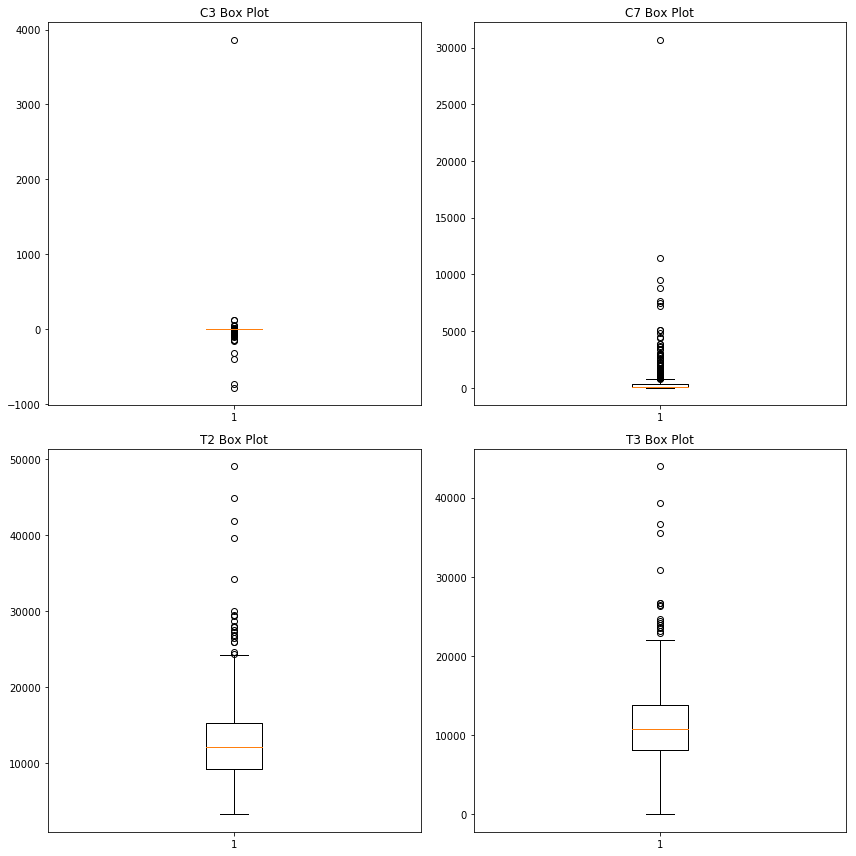

In [35]:
fig, axs = plt.subplots(2, 2, tight_layout=True, figsize=(12,12))

axs[0,0].boxplot(x1)
axs[0,0].set_title('C3 Box Plot')

axs[0,1].boxplot(x2)
axs[0,1].set_title('C7 Box Plot')

axs[1,0].boxplot(x3)
axs[1,0].set_title('T2 Box Plot')

axs[1,1].boxplot(x4)
axs[1,1].set_title('T3 Box Plot')

plt.show()

In [36]:
# #Only plot numerical columns so drop non-numerical
# for col in [i for i in list(null_cols.index) if i not in ['I3','C2','data_updated']]:
#     #Create Histograms
#     data[col].hist()
#     #plt.xlabel(col)
#     plt.title(col)
#     plt.axvline(data[col].mean(), color = 'red')
#     plt.axvline(data[col].median(), color = 'green')
#     plt.show()

The difference between mean and median appears to be small, but the amount of outliers makes median a safer method for imputation for each of these fields.

In [37]:
# There are a lot of heavy outliers in the dataset, so median is used for many imputations

# imputing = {
#     'C1': 'mean',
#     'C2': 'mode', # categorical column
#     'C3': 'median',
#     'C4': 'mean',
#     'C5': 'mean',
#     'C6': 'mean',
#     'C7': 'mean',
#     'T1': 'mean',
#     'T2': 'mean',
#     'T3': 'mean',
#     'T4': 'mean',
#     'T5': 'mean',
#     'S1': 'mean',
#     'S2': 'mean',
#     'S3': 'mean'
# }

imputing = {
    'C3': 'median',
    'C7': 'median',
    'T2': 'median',
    'T3': 'median'
 }

data_w_imputed = data.copy()

for key in imputing.keys():
    data_w_imputed = impute_nulls_df(data_w_imputed, key, imputing[key])

Check to make sure only the original four columns have null values and the imputed ones have none.

In [38]:
pd.isna(data_w_imputed).sum()

I1               0
I2               0
I3               0
P(IPO)           0
P(H)             0
P(L)             0
P(1Day)          0
C1               0
C2               0
C3              23
C4               0
C5               0
C6               0
C7              60
T1               0
T2               2
T3               2
T4               0
T5               0
S1               0
S2               0
S3               0
data_updated     0
C3_imputed       0
C7_imputed       0
T2_imputed       0
T3_imputed       0
dtype: int64

Now there are new imputed columns at the end of the dataframe as can be viewed below:

In [39]:
data_w_imputed.head()

,I1,I2,I3,P(IPO),P(H),P(L),P(1Day),C1,C2,C3,C4,C5,C6,C7,T1,T2,T3,T4,T5,S1,S2,S3,data_updated,C3_imputed,C7_imputed,T2_imputed,T3_imputed
0,AATI,ADVANCED ANALOGIC TECHNOLOGIES INC,3674.0,10.0,9.5,8.5,11.870000,122.0,1.0,3.43,0.029074,40962052.0,10600000.0,51.345,470.0,12719.0,11560.0,301.0,690.0,62.0,117.0,139.0,0,3.43,51.345,12719.0,11560.0
1,ABPI,ACCENTIA BIOPHARMACEUTICALS INC,2834.0,8.0,10.0,8.0,7.250000,259.0,0.0,-1.62,-0.013352,28869196.0,2400000.0,25.936,791.0,21792.0,19585.0,510.0,1120.0,71.0,242.0,237.0,0,-1.62,25.936,21792.0,19585.0
2,ACAD,ACADIA PHARMACEUTICALS INC,2834.0,7.0,14.0,12.0,6.700000,90.0,1.0,-1.24,0.020715,16845668.0,5000000.0,7.378,201.0,5262.0,4785.0,128.0,325.0,61.0,33.0,60.0,0,-1.24,7.378,5262.0,4785.0
3,ACHN,ACHILLION PHARMACEUTICALS INC,2834.0,11.5,16.0,14.0,12.390000,209.0,1.0,-0.91,0.020023,14848637.0,4500000.0,8.526,328.0,8259.0,7574.0,177.0,509.0,80.0,59.0,110.0,0,-0.91,8.526,8259.0,7574.0
4,ACLI,AMERICAN COMMERCIAL LINES INC.,4492.0,21.0,21.0,19.0,56.599998,80.0,1.0,0.07,-0.034895,30741716.0,8250000.0,632.298,572.0,14830.0,13176.0,336.0,720.0,67.0,149.0,167.0,0,0.07,632.298,14830.0,13176.0


Drop the original null columns and keep only the new ones

In [40]:
data_w_imputed = data_w_imputed.drop(columns=['C3','C7','T2','T3'])

# Step 3B: Seperate Categorical and Continuous Fields, drop non-imputed

The ID field of I1 will be kept in both in order to merge as needed.

In [41]:
cat_fields = ['I1','I2', 'I3','C2','data_updated']
cat_data = data_w_imputed[cat_fields]

In [42]:
cont_data = data_w_imputed[['I1'] + list(set(data_w_imputed.columns) - set(cat_data.columns))]

In [43]:
cont_data.head()

,I1,S1,S3,T2_imputed,T1,S2,C7_imputed,C3_imputed,P(L),C4,T4,C5,C1,P(IPO),P(1Day),C6,T3_imputed,P(H),T5
0,AATI,62.0,139.0,12719.0,470.0,117.0,51.345,3.43,8.5,0.029074,301.0,40962052.0,122.0,10.0,11.870000,10600000.0,11560.0,9.5,690.0
1,ABPI,71.0,237.0,21792.0,791.0,242.0,25.936,-1.62,8.0,-0.013352,510.0,28869196.0,259.0,8.0,7.250000,2400000.0,19585.0,10.0,1120.0
2,ACAD,61.0,60.0,5262.0,201.0,33.0,7.378,-1.24,12.0,0.020715,128.0,16845668.0,90.0,7.0,6.700000,5000000.0,4785.0,14.0,325.0
3,ACHN,80.0,110.0,8259.0,328.0,59.0,8.526,-0.91,14.0,0.020023,177.0,14848637.0,209.0,11.5,12.390000,4500000.0,7574.0,16.0,509.0
4,ACLI,67.0,167.0,14830.0,572.0,149.0,632.298,0.07,19.0,-0.034895,336.0,30741716.0,80.0,21.0,56.599998,8250000.0,13176.0,21.0,720.0


# Step 4: Create values outlined in Data Dictionary
- T1-T5 as ratios
- S1-S3 as ratios
- C3', C5', C6'
- Y1, Y2
- Any additional that seem reasonable

Reference here: https://github.com/fairfield-university-ba545/project1-archana-s-team/blob/master/DataDictionary20190115.pdf

In [44]:
# Example Ratio, divide the column with the number of words and columns with number of sentences to get words per sentence
cont_data['words_per_sentence'] = cont_data.T2_imputed / cont_data.T1
cont_data['real_word_per'] = cont_data.T3_imputed / cont_data.T2_imputed
cont_data['non_real_word_per'] = (cont_data.T2_imputed - cont_data.T3_imputed) / cont_data.T2_imputed
cont_data['short_sentences'] = cont_data.T1 - cont_data.T4
cont_data['short_sentences_per'] = cont_data.short_sentences / cont_data.T1
cont_data['long_sentences_per'] = cont_data.T4 / cont_data.T1
cont_data['long_words_per'] = cont_data.T5 / cont_data.T2_imputed


# Also try against iqr standardized ones, can pick which is best to use later on
# data_imputed_iqr['words_per_sentence_imputed_iqr_standardized'] = data_imputed_iqr.T2_imputed_iqr_standardized / data_imputed_iqr.T1_imputed_iqr_standardized
# data_imputed_iqr['real_word_per_imputed_iqr_standardized'] = data_imputed_iqr.T3_imputed_iqr_standardized / data_imputed_iqr.T2_imputed_iqr_standardized
# data_imputed_iqr['non_real_word_per_imputed_iqr_standardized'] = (data_imputed_iqr.T2_imputed_iqr_standardized - data_imputed_iqr.T3_imputed_iqr_standardized) / data_imputed_iqr.T2_imputed_iqr_standardized
# data_imputed_iqr['short_sentences_imputed_iqr_standardized'] = data_imputed_iqr.T1_imputed_iqr_standardized - data_imputed_iqr.T4_imputed_iqr_standardized
# data_imputed_iqr['short_sentences_per_imputed_iqr_standardized'] = data_imputed_iqr.short_sentences_imputed_iqr_standardized / data_imputed_iqr.T1_imputed_iqr_standardized
# data_imputed_iqr['long_sentences_per_imputed_iqr_standardized_'] = data_imputed_iqr.T4_imputed_iqr_standardized / data_imputed_iqr.T1_imputed_iqr_standardized

/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [45]:
# Percentage of positive words by dividing count of positive words by total words
cont_data['pos_words_percent'] = cont_data.S1 / (cont_data.S1 + cont_data.S2 + cont_data.S3)
cont_data['neg_words_percent'] = cont_data.S2 / (cont_data.S1 + cont_data.S2 + cont_data.S3)
cont_data['uncertain_words_percent'] = cont_data.S3 / (cont_data.S1 + cont_data.S2 + cont_data.S3)

# data_imputed_iqr['pos_words_percent_imputed_iqr_standardized'] = data_imputed_iqr.S1_imputed_iqr_standardized / (data_imputed_iqr.S1_imputed_iqr_standardized + 
#                                                                        data_imputed_iqr.S2_imputed_iqr_standardized + data_imputed_iqr.S3_imputed_iqr_standardized)
# data_imputed_iqr['neg_words_percent_imputed_iqr_standardized'] = data_imputed_iqr.S2_imputed_iqr_standardized / (data_imputed_iqr.S1_imputed_iqr_standardized + 
#                                                                        data_imputed_iqr.S2_imputed_iqr_standardized + data_imputed_iqr.S3_imputed_iqr_standardized)
# data_imputed_iqr['uncertain_words_percent_imputed_iqr_standardized'] = data_imputed_iqr.S3_imputed_iqr_standardized / (data_imputed_iqr.S1_imputed_iqr_standardized + 
#                                                                              data_imputed_iqr.S2_imputed_iqr_standardized + 
#                                                                              data_imputed_iqr.S3_imputed_iqr_standardized)

In [46]:
cont_data['total_shares'] = cont_data.C5 + cont_data.C6
cont_data['sales_per_share'] = cont_data.C7_imputed/cont_data.total_shares
cont_data['outstanding_share_per'] = cont_data.C5/cont_data.total_shares
cont_data['offering_share_per'] = cont_data.C6/cont_data.total_shares


# data_imputed_iqr['total_shares_imputed_iqr_standardized'] = data_imputed_iqr.C5_imputed_iqr_standardized + data_imputed_iqr.C6_imputed_iqr_standardized
# data_imputed_iqr['sales_per_share_imputed_iqr_standardized'] = data_imputed_iqr.C7_imputed_iqr_standardized/data_imputed_iqr.total_shares_imputed_iqr_standardized

In [47]:
cont_data['C3_prime'] = cont_data.C3_imputed.apply(lambda x: 1 if x>0 else 0)
cont_data['C5_prime'] = cont_data['C5']/ cont_data['C6']
cont_data['P(mid)'] = (cont_data['P(H)'] + cont_data['P(L)'])/2
cont_data['C6_prime'] = (cont_data['P(IPO)'] - cont_data['P(mid)'])/cont_data['P(mid)']*100
cont_data['Y1'] = cont_data.apply(lambda row: 1 if row['P(IPO)'] < row['P(mid)'] else 0, axis = 1)
cont_data['Y2'] = cont_data.apply(lambda row: 1 if row['P(IPO)'] < row['P(1Day)'] else 0, axis = 1)


# data_imputed_iqr['C3\'_imputed_iqr_standardized'] = data_imputed_iqr.C3_imputed_iqr_standardized.apply(lambda x: 1 if x>0 else 0)
# data_imputed_iqr['C5\'_imputed_iqr_standardized'] = data_imputed_iqr['C5_imputed_iqr_standardized']/ data_imputed_iqr['C6_imputed_iqr_standardized']
# data_imputed_iqr['P(mid)_imputed_iqr_standardized'] = (data_imputed_iqr['P(H)'] + data_imputed_iqr['P(L)'])/2
# data_imputed_iqr['C6\'_imputed_iqr_standardized'] = (data_imputed_iqr['P(IPO)'] - data_imputed_iqr['P(mid)'])/data_imputed_iqr['P(mid)']*100

SIC codes classified as follows, can be used for binning

<table class="wikitable sortable jquery-tablesorter">

<thead><tr>
<th class="headerSort" tabindex="0" role="columnheader button" title="Sort ascending">Range of SIC Codes
</th>
<th class="headerSort" tabindex="0" role="columnheader button" title="Sort ascending">Division
</th></tr></thead><tbody>
<tr>
<td>0100-0999
</td>
<td>Agriculture, Forestry and Fishing
</td></tr>
<tr>
<td>1000-1499
</td>
<td>Mining
</td></tr>
<tr>
<td>1500-1799
</td>
<td>Construction
</td></tr>
<tr>
<td>1800-1999
</td>
<td>not used
</td></tr>
<tr>
<td>2000-3999
</td>
<td>Manufacturing
</td></tr>
<tr>
<td>4000-4999
</td>
<td>Transportation, Communications, Electric, Gas and Sanitary service
</td></tr>
<tr>
<td>5000-5199
</td>
<td>Wholesale Trade
</td></tr>
<tr>
<td>5200-5999
</td>
<td>Retail Trade
</td></tr>
<tr>
<td>6000-6799
</td>
<td>Finance, Insurance and Real Estate
</td></tr>
<tr>
<td>7000-8999
</td>
<td>Services
</td></tr>
<tr>
<td>9100-9729
</td>
<td>Public Administration
</td></tr>
<tr>
<td>9900-9999
</td>
<td>Nonclassifiable
</td></tr></tbody><tfoot></tfoot></table>

In [48]:
def bin_sic(val):
    try:
        val = int(val)
    except Exception as e:
        return 'Other'
    if val <= 999:
        return 'Agriculture, Forestry and Fishing'
    if val <= 1499:
        return 'Mining'
    if val <= 1799:
        return 'Construction'
    if val <= 1999:
        return 'Other'
    if val <= 3999:
        return 'Manufacturing'
    if val <= 4999:
        return 'Transportation, Communications, Electric, Gas and Sanitary service'
    if val <= 5199:
        return 'Wholesale Trade'
    if val <= 5999:
        return 'Retail Trade'
    if val <= 6799:
        return 'Finance, Insurance and Real Estate'
    if val <= 8999:
        return 'Services'
    if val <= 9729:
        return 'Public Administration'
    return 'Other'
    

In [49]:
cat_data['industry_bin'] = cat_data['I3'].apply(bin_sic)
cat_data['industry_bin'] = cat_data['industry_bin'].astype('category')
cat_data['C3_prime'] = cont_data['C3_prime']

/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

Create seperate DataFrame containing all the target variable information.

In [50]:
target_df = cont_data[['I1','Y1','Y2']]

Drop all fields used in creating additional fields.

In [51]:
continuous_df = cont_data.copy()
continuous_df = continuous_df.drop(columns = ['S1','S2','S3','T1','T2_imputed','T3_imputed',
                                              'T4','T5', 'P(IPO)', 'P(L)', 'P(H)', 'P(1Day)', 'P(mid)',
                                             'C5','C6','C3_prime', 'Y1','Y2'])
continuous_df.head()

,I1,C7_imputed,C3_imputed,C4,C1,words_per_sentence,real_word_per,non_real_word_per,short_sentences,short_sentences_per,long_sentences_per,long_words_per,pos_words_percent,neg_words_percent,uncertain_words_percent,total_shares,sales_per_share,outstanding_share_per,offering_share_per,C5_prime,C6_prime
0,AATI,51.345,3.43,0.029074,122.0,27.061702,0.908876,0.091124,169.0,0.359574,0.640426,0.054250,0.194969,0.367925,0.437107,51562052.0,9.957905e-07,0.794422,0.205578,3.864345,11.111111
1,ABPI,25.936,-1.62,-0.013352,259.0,27.549937,0.898724,0.101276,281.0,0.355247,0.644753,0.051395,0.129091,0.440000,0.430909,31269196.0,8.294425e-07,0.923247,0.076753,12.028832,-11.111111
2,ACAD,7.378,-1.24,0.020715,90.0,26.179104,0.909350,0.090650,73.0,0.363184,0.636816,0.061764,0.396104,0.214286,0.389610,21845668.0,3.377329e-07,0.771122,0.228878,3.369134,-46.153846
3,ACHN,8.526,-0.91,0.020023,209.0,25.179878,0.917060,0.082940,151.0,0.460366,0.539634,0.061630,0.321285,0.236948,0.441767,19348637.0,4.406512e-07,0.767425,0.232575,3.299697,-23.333333
4,ACLI,632.298,0.07,-0.034895,80.0,25.926573,0.888469,0.111531,236.0,0.412587,0.587413,0.048550,0.174935,0.389034,0.436031,38991716.0,1.621621e-05,0.788417,0.211583,3.726269,5.000000


In [52]:
categorical_df = cat_data.copy()
categorical_df = categorical_df.drop(columns = ['I3','I2'])
categorical_df.head()

,I1,C2,data_updated,industry_bin,C3_prime
0,AATI,1.0,0,Manufacturing,1
1,ABPI,0.0,0,Manufacturing,0
2,ACAD,1.0,0,Manufacturing,0
3,ACHN,1.0,0,Manufacturing,0
4,ACLI,1.0,0,"Transportation, Communications, Electric, Gas ...",1


Save categorical and continuous DFs

In [53]:
categorical_df.to_csv('categorical_df.csv')
continuous_df.to_csv('continuous_df.csv')
target_df.to_csv('target_df.csv')

# Step 5: Standardize outliers with IQR
- Alter some of the outlier values to be at the end of the 1.5 * IQR range for more accuracy in model

In [54]:
#def interquartile_range_replacement(df, col):
#    '''
#    Use interquartile range to address outliers and update columns showing those we augmented to reflect the changes made
#    '''
#    quartile_data = df[col].describe()
#    q1 = quartile_data['25%']
#    q3 = quartile_data['75%']
#    iqr = q3 - q1
#    high = quartile_data['50%'] + (1.5 * iqr)
#    low = quartile_data['50%'] - (1.5 * iqr)
#    
#    outliers_augmented = df[col].apply(lambda x: low if x < low else (high if x > high else x))
#    
#    df[col + '_iqr_standardized'] = outliers_augmented
#    #df['data_updated'] = np.where((df['data_updated'] == 1) | (df[col] != df[col + '_iqr_standardized']), 1, 0)
#    return df

In [55]:
continuous_df.head()

,I1,C7_imputed,C3_imputed,C4,C1,words_per_sentence,real_word_per,non_real_word_per,short_sentences,short_sentences_per,long_sentences_per,long_words_per,pos_words_percent,neg_words_percent,uncertain_words_percent,total_shares,sales_per_share,outstanding_share_per,offering_share_per,C5_prime,C6_prime
0,AATI,51.345,3.43,0.029074,122.0,27.061702,0.908876,0.091124,169.0,0.359574,0.640426,0.054250,0.194969,0.367925,0.437107,51562052.0,9.957905e-07,0.794422,0.205578,3.864345,11.111111
1,ABPI,25.936,-1.62,-0.013352,259.0,27.549937,0.898724,0.101276,281.0,0.355247,0.644753,0.051395,0.129091,0.440000,0.430909,31269196.0,8.294425e-07,0.923247,0.076753,12.028832,-11.111111
2,ACAD,7.378,-1.24,0.020715,90.0,26.179104,0.909350,0.090650,73.0,0.363184,0.636816,0.061764,0.396104,0.214286,0.389610,21845668.0,3.377329e-07,0.771122,0.228878,3.369134,-46.153846
3,ACHN,8.526,-0.91,0.020023,209.0,25.179878,0.917060,0.082940,151.0,0.460366,0.539634,0.061630,0.321285,0.236948,0.441767,19348637.0,4.406512e-07,0.767425,0.232575,3.299697,-23.333333
4,ACLI,632.298,0.07,-0.034895,80.0,25.926573,0.888469,0.111531,236.0,0.412587,0.587413,0.048550,0.174935,0.389034,0.436031,38991716.0,1.621621e-05,0.788417,0.211583,3.726269,5.000000


In [56]:
cont_iqr_standardized = continuous_df.copy()
for i in [col for col in list(cont_iqr_standardized.columns[1:])]:
    cont_iqr_standardized = interquartile_range_replacement(cont_iqr_standardized, i)

# Step 6: Data Standardization

## Continuous Values
- Min-Max Scaling
- Binning

## Categorical
- Identify viable categories (create as few as possible)
- One-hot-encode if needed

In [57]:
cont_min_max_scaled = pd.DataFrame(min_max_scale_df(cont_iqr_standardized[cont_iqr_standardized.columns.tolist()[1:]]), 
             columns = cont_iqr_standardized.columns.tolist()[1:])
cont_min_max_scaled['I1'] = cont_iqr_standardized['I1'].values
cont_min_max_scaled.head()

,C7_imputed,C3_imputed,C4,C1,words_per_sentence,real_word_per,non_real_word_per,short_sentences,short_sentences_per,long_sentences_per,long_words_per,pos_words_percent,neg_words_percent,uncertain_words_percent,total_shares,sales_per_share,outstanding_share_per,offering_share_per,C5_prime,C6_prime,C7_imputed_iqr_standardized,C3_imputed_iqr_standardized,C4_iqr_standardized,C1_iqr_standardized,words_per_sentence_iqr_standardized,real_word_per_iqr_standardized,non_real_word_per_iqr_standardized,short_sentences_iqr_standardized,short_sentences_per_iqr_standardized,long_sentences_per_iqr_standardized,long_words_per_iqr_standardized,pos_words_percent_iqr_standardized,neg_words_percent_iqr_standardized,uncertain_words_percent_iqr_standardized,total_shares_iqr_standardized,sales_per_share_iqr_standardized,outstanding_share_per_iqr_standardized,offering_share_per_iqr_standardized,C5_prime_iqr_standardized,C6_prime_iqr_standardized,I1
0,0.001671,0.169794,0.749962,0.053924,0.372945,0.944727,0.055273,0.200306,0.224992,0.775008,0.580726,0.470416,0.457657,0.507764,0.017940,0.011705,0.745692,0.254308,0.035990,0.478927,0.103267,1.000000,0.646105,0.554455,0.524304,0.650533,0.349467,0.526749,0.458866,0.541134,0.586770,0.469847,0.569242,0.464101,0.523850,0.085818,0.521728,0.478272,0.522171,0.684926,AATI
1,0.000843,0.168708,0.583748,0.119884,0.394163,0.934175,0.065825,0.371560,0.219755,0.780245,0.550219,0.314935,0.601349,0.495247,0.009994,0.009744,0.913135,0.086865,0.118042,0.348659,0.052090,0.054639,0.335391,1.000000,0.564129,0.521883,0.478117,0.987654,0.443639,0.556361,0.480447,0.158061,0.813082,0.441796,0.291806,0.071443,1.000000,0.000000,1.000000,0.380833,ABPI
2,0.000238,0.168790,0.717213,0.038517,0.334588,0.945220,0.054780,0.053517,0.229360,0.770640,0.661030,0.945124,0.151358,0.411846,0.006303,0.003949,0.715407,0.284593,0.031013,0.143236,0.014711,0.159107,0.584885,0.396040,0.452311,0.656534,0.343466,0.131687,0.471565,0.528435,0.866645,1.000000,0.049463,0.293168,0.184050,0.028953,0.434328,0.565672,0.439812,0.000000,ACAD
3,0.000275,0.168861,0.714502,0.095811,0.291162,0.953234,0.046766,0.172783,0.346964,0.653036,0.659600,0.768541,0.196538,0.517175,0.005325,0.005162,0.710602,0.289398,0.030315,0.277011,0.017024,0.249828,0.579818,0.985149,0.370805,0.754237,0.245763,0.452675,0.813476,0.186524,0.861660,1.000000,0.126132,0.480873,0.155497,0.037847,0.420464,0.579536,0.428264,0.213581,ACHN
4,0.020605,0.169072,0.499347,0.033702,0.323613,0.923515,0.076485,0.302752,0.289146,0.710854,0.519817,0.423133,0.499742,0.505592,0.013018,0.191097,0.737886,0.262114,0.034602,0.443103,1.000000,0.519244,0.177617,0.346535,0.431712,0.391930,0.608070,0.802469,0.645379,0.354621,0.374488,0.375031,0.640658,0.460230,0.380111,1.000000,0.499201,0.500799,0.499207,0.601301,ACLI


In [58]:
def combine_industry_col(val):
    if val in ['Mining','Finance, Insurance and Real Estate', 'Construction', 'Agriculture, Forestry and Fishing']:
        return 'Other'
    elif val == 'Mining':
        return 'Other'
#     elif val in ['Retail Trade','Wholesale Trade']:
#         return 'Trade'
    elif val in ['Retail Trade','Wholesale Trade', 'Transportation, Communications, Electric, Gas and Sanitary service']:
        return 'Other'
    else:
        return val

In [59]:
categorical_df['industry_bin'] = categorical_df['industry_bin'].apply(combine_industry_col)

In [60]:
def one_hot_encode(df, col):
    return pd.get_dummies(df[col], prefix = col + '_')

In [61]:
categorical_df = pd.concat([categorical_df, one_hot_encode(categorical_df, 'industry_bin')], axis = 1)

In [62]:
categorical_df.drop(columns=['industry_bin'], inplace = True)

In [63]:
categorical_df.head()

,I1,C2,data_updated,C3_prime,industry_bin__Manufacturing,industry_bin__Other,industry_bin__Services
0,AATI,1.0,0,1,1,0,0
1,ABPI,0.0,0,0,1,0,0
2,ACAD,1.0,0,0,1,0,0
3,ACHN,1.0,0,0,1,0,0
4,ACLI,1.0,0,1,0,1,0


In [64]:
cont_min_max_scaled.to_csv('cont_min_max_scaled_standardized.csv')
categorical_df.to_csv('categorical_df_standardized.csv')

# Handled in other notebook

# Step 7: Check Normality of fields

## Handled in other notebook

- Histogram
- Skew
- Shapiro test for normality: a p-value of lower than 0.05 implies non-normal values

In [65]:
def check_normal_by_hist(df, col):
    '''
    Creates a histogram to view values to check normality
    
    params:
    df - DataFrame
    col - Columns of DataFrame you want to test
    
    return:
    Void, however will print a histogram
    
    '''
    df[col].hist()
    plt.title(col)
    plt.show()
    
def check_normal_by_shapiro(df, col):
    '''
    Runs the Shapiro normality test on the values from a dataframe
    
    params:
    df - DataFrame
    col - Columns of DataFrame you want to test
    
    return:
    tuple - (Test Statistic, p-value)
    
    A p-value lower than 0.05 implies the values are NOT normal
    
    '''
    
    return shapiro(df[col].values)

def check_skew(df, col):
    return skew(df[col])

def bad_skew(df, col_list):
    bad_ones = []
    skews = []
    for i in col_list:
        skw = skew(df[i])
        if (skw > 0.5) or (skw < -0.5):
            bad_ones.append(i)
            skews.append(skw)
    return bad_ones, skews
    

In [66]:
for i in [j for j in data_imputed_iqr if 'imputed' in j][:19]:
    check_normal_by_hist(data_imputed_iqr, i)
    print(check_normal_by_shapiro(data_imputed_iqr, i))
    print('skew is ' + str(check_skew(data_imputed_iqr, i)))

NameError: name 'data_imputed_iqr' is not defined

In [ ]:
for i in [j for j in data_imputed_iqr if 'iqr_standardized' in j]:
    check_normal_by_hist(data_imputed_iqr, i)
    print(check_normal_by_shapiro(data_imputed_iqr, i))
    print('skew is ' + str(check_skew(data_imputed_iqr, i)))

IQR Standardized look ALOT better than the others

In [ ]:
bad_skew(data_imputed_iqr, [j for j in data_imputed_iqr if 'iqr_standardized' in j])


# Step 6B: Create New Columns with Normalized values of non-normal fields
- Try applying squaring, log(), square root, 1/x function
- Leverage Histograms and Shapiro-Wilk test

In [ ]:
def normalize_log(col_vals):
    return np.log(col_vals + min(col_vals))

def normalize_sqrt(col_vals):
    if min(col_vals) < 0:
        print('Can\'t sqrt with negative values')
        return
    return np.sqrt(col_vals)

def normalize_recip_sqrt(col_vals):
    if min(col_vals) < 0:
        print('Can\'t sqrt with negative values')
        return
    return 1/np.sqrt(col_vals)

def normalize_sigmoid(col_vals):
    return [1/(1+np.e**(-i)) for i in col_vals]

def normalize_div(col_vals):
    return 1/col_vals

def normalize_log_div(col_vals):
    return 1/np.log(col_vals + min(col_vals))

def normalize_shift_left(col_vals):
    return col_vals - len(col_vals)

def normalize_shift_right(col_vals):
    return col_vals + len(col_vals)

def normalize_by_power(col_vals):
    return [i**2 for i in col_vals]

def normalize_by_e(col_vals):
    return [np.e **(i + min(col_vals)) for i in col_vals]

def normalize_data(df, col, normalize_function = None):
    '''
    Given a dataframe, column, and type of normalization, attempt to make the field normal.
    
    params:
    df - dataframe
    col - string - column to normalize
    normalize_function - function - type of normalization to perform. If blank then all will be performed and compared.
        options are functions above
        
    '''
    
    if normalize_function is not None:
        try:
            new_vals = normalize_function(df[col].values)
            p_val = shapiro(new_vals)[1]
            valid = 'Normal' if p_val > 0.05 else 'Non-Normal'
            print('Shapiro Test says given function made the data ' + valid +' with a p-value of ' + str(p_val))
            if p_val > 0.05:
                plt.hist(new_vals)
                return True
            else:
                return False
        except Exception as e:
            print(e)
    
#     else:
#         print('Running Tests')
#         normalize_options = [normalize_log, normalize_sqrt, normalize_div, normalize_log_div, normalize_shift_left, 
#                             normalize_shift_right, normalize_by_power, normalize_by_e]
#         values = df[col].values
#         baseline = shapiro(values)[1]
        
#         if baseline > 0.05:
#             print('Already Normal')
#             return
        
#         else:
#             p_vals = []
#             normalized_dat = []
#             for i in normalize_options:
#                 try:
#                     normalized_dat.append(i(values))
#                 except Exception as e:
#                     normalized_dat.append(None)
#                 try:
#                     p_vals.append(shapiro(normalized_dat[-1])[1])
#                 except Exception as e:
#                     p_vals.append(-1)
#             idx = p_vals.index(max(p_vals))
            
#             print(normalize_options[idx])
#             return normalized_dat[idx]
    

# Merge the normalized data and original data

In [67]:
normalized_cont = pd.read_csv('normalized_continuous_peter.csv').drop(columns = ['Unnamed: 0'])

In [68]:
all_cont = cont_min_max_scaled.merge(normalized_cont, left_on = 'I1', right_on = 'I1_normalized', how = 'inner')

In [69]:
#all_cont[all_cont.I1 != all_cont.I1_normalized][['I1','I1_normalized']]
all_cont = all_cont[~pd.isna(all_cont.I1)]

# Merge Categorical Variables for final feature set candidates

In [70]:
feat_mat = all_cont.merge(categorical_df)

In [71]:
feat_mat.drop(columns = ['I1_normalized'], inplace = True)

# Z Score Standardization

In [108]:
def z_score(df, col):
    df[col + '_zscore'] = zscore(df[col].values)

In [109]:
#zscore(data_stand.C7_imputed.values)

In [110]:
data_stand = feat_mat.copy() 
for col in data_stand.drop(['I1'],axis=1).columns:
    print("Column: ", col)
    
    z_score(data_stand,col)
    print(data_stand[col + '_zscore'].head())
    
data_stand.drop(data.columns, axis=1)

Column:  C7_imputed
0   -0.264556
1   -0.280547
2   -0.292227
3   -0.291505
4    0.101082
Name: C7_imputed_zscore, dtype: float64
Column:  C3_imputed
0    0.021210
1   -0.010649
2   -0.008252
3   -0.006170
4    0.000013
Name: C3_imputed_zscore, dtype: float64
Column:  C4
0    0.655462
1   -0.617924
2    0.404564
3    0.383798
4   -1.264526
Name: C4_zscore, dtype: float64
Column:  C1
0   -0.180472
1    0.716179
2   -0.389909
3    0.388934
4   -0.455358
Name: C1_zscore, dtype: float64
Column:  words_per_sentence
0   -0.060898
1    0.083187
2   -0.321364
3   -0.616249
4   -0.395889
Name: words_per_sentence_zscore, dtype: float64
Column:  real_word_per
0    0.295912
1    0.138864
2    0.303238
3    0.422509
4   -0.019774
Name: real_word_per_zscore, dtype: float64
Column:  non_real_word_per
0   -0.295912
1   -0.138864
2   -0.303238
3   -0.422509
4    0.019774
Name: non_real_word_per_zscore, dtype: float64
Column:  short_sentences
0   -0.055238
1    1.541152
2   -1.423572
3   -0.311800
4    

/opt/tljh/user/lib/python3.6/site-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


KeyError: "['I2' 'I3' 'P(IPO)' 'P(H)' 'P(L)' 'P(1Day)' 'C3' 'C5' 'C6' 'C7' 'T1' 'T2'\n 'T3' 'T4' 'T5' 'S1' 'S2' 'S3'] not found in axis"

In [ ]:
#Only plot numberical columns so drop non-numerical
 for col in data.drop(['I1','I2','I3'],axis=1).columns:
     print("Column: ", col)
    
     #Create Histograms
     data[col].hist()
     plt.xlabel(col)
     plt.title('Histogram')
     plt.show()
    
     #Find outliers within 3 standard deviations of mean
     outliers_low = (data[col].mean() - 3*data[col].std())
     outliers_high = (data[col].mean() + 3*data[col].std())
    
     #Print outlier values and counts of how many outliers
     print("outliers low value <", outliers_low)
     print("outlier low count: ", data[col][data[col] < outliers_low].count())
     print("outliers high value >", outliers_high) 
     print("outlier high count: ", data[col][data[col] > outliers_high].count())
     print('\n')

In [ ]:
def standard_deviation(df, col):
    '''
    Use standard deviation to address outliers and update columns showing those we augmented to reflect the changes made
    '''
    standard_dev_data = df[col].describe()
    outliers_low = quartile_data['25%']
    outliers_high = quartile_data['75%']
    iqr = q3 - q1
    high = quartile_data['50%'] + (1.5 * iqr)
    low = quartile_data['50%'] - (1.5 * iqr)
    
    outliers_augmented = df[col].apply(lambda x: low if x < low else (high if x > high else x))
    
    df[col + '_iqr_standardized'] = outliers_augmented

    return df

In [ ]:
def interquartile_range_replacement(df, col):
    '''
    Use interquartile range to address outliers and update columns showing those we augmented to reflect the changes made
    '''
    quartile_data = df[col].describe()
    q1 = quartile_data['25%']
    q3 = quartile_data['75%']
    iqr = q3 - q1
    high = quartile_data['50%'] + (1.5 * iqr)
    low = quartile_data['50%'] - (1.5 * iqr)
    
    outliers_augmented = df[col].apply(lambda x: low if x < low else (high if x > high else x))
    
    df[col + '_iqr_standardized'] = outliers_augmented
 
    return df

# Step 7: Correlation of input variables
- Line plot to display correlation
- HeatMap to check correlation

First look at those which are not normalized or standardized as we would expect alternative versions of the same field to be heavilly correlated with the original.

In [ ]:
corr = cont_min_max_scaled[[i for i in list(cont_min_max_scaled.columns) if 'standardized' not in i]].corr()
plt.figure(figsize=(15,15))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

We expect the diagnol to be a perfect correlation as it represents one field against itself. We also see others which are potentially correlated and need to be addressed. 

Some of these fields make intuitive sense as they were created off of the same input values. Initially both sets were retained as it was unknown which had the most predictive power. We can use this chart to pick subsets to be tested against each other later on.

In [ ]:
corr = cont_min_max_scaled[[i for i in list(cont_min_max_scaled.columns) if 'standardized' in i]].corr()
plt.figure(figsize=(15,15))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Those standardized through leveraging IQR seem to present a very similar image and corersponding correlations. However, it can be seen that several correlations seem to have more magnitude once the IQR trimming mechanism was used. This implies that handling the outliers in this fashion caused more relationships to be seen.

The Normalized data can also be viewed. It appears as if the correlation remains intact which implies that the normalization process did not leak any valuable data. 

In [ ]:
corr = normalized_cont[[i for i in list(normalized_cont.columns) if 'standardized' not in i]].corr()
plt.figure(figsize=(15,15))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [ ]:
corr = normalized_cont[[i for i in list(normalized_cont.columns) if 'standardized' in i]].corr()
plt.figure(figsize=(15,15))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

The Correlation plots can be used to group items together during feature selection to choose the best option to represent similar data.

In [ ]:
high_corrs = corr[((corr>0.5) | (corr < -0.5)) & (corr != 1)]

In [ ]:
high_corr_map = {}

for i in high_corrs.columns:
    val = list(high_corrs[i].dropna().index)
    if len(val) > 0:
        high_corr_map[i] = list(high_corrs[i].dropna().index)

# Step 9: Identify and remove redundunt information through Feature Selection
- Leverage correlation analysis
- RFE (recursive feature elimination) to select valuable items
- JointPlots against target

# Methodology 
- There will be a few different ways of representing the same information
    - IQR updated
    - Normalized
    - Scaled
- Take each of these in RFE to pick a "winner"
- Keep only the "winners" and use these in PCA

Only test fields intented for final results (nothing used in other features created, nothing relating to target variable)

In [ ]:
def get_important_features_rfe(xTrain, yTrain, num_feats):
    '''
    Takes training values and returns the most important features in order
    '''
    clf = LogisticRegression(random_state=123)
    selector = RFE(clf, num_feats, step=1)
    selector.fit(xTrain, yTrain)
    
    return [x for _,x in sorted(zip(selector.ranking_, list(xTrain.columns)))]
    
    

In [ ]:
test_feats = {
    'C1': ['C1', 'C1_normalized'],
    'C3': ['C3_imputed','C3_imputed_iqr_standardized','C3_imputed_normalized', 'C3_imputed_iqr_standardized_normalized'],
    'C4': ['C4', 'C4_iqr_standardized', 'C4_normalized', 'C4_iqr_standardized_normalized'],
    'C5_prime': ['C5_prime', 'C5_prime_iqr_standardized','C5_prime_normalized','C5_prime_iqr_standardized_normalized'],
    'C6_prime': ['C6_imputed_std_scaled', 'C6_imputed_iqr_standardized_std_scaled'],
    'C7': ['C7_imputed_std_scaled', 'C7_imputed_iqr_standardized_std_scaled'],
    'words_per_sentence': ['words_per_sentence_imputed_std_scaled', 'words_per_sentence_imputed_iqr_standardized_std_scaled'],
    'real_word_per': ['real_word_per_imputed_std_scaled','real_word_per_imputed_iqr_standardized_std_scaled'],
    #'non_real_word_per': ['non_real_word_per_imputed_std_scaled','non_real_word_per_imputed_iqr_standardized_std_scaled'],
    'short_sentences_per': ['short_sentences_imputed_std_scaled', 'short_sentences_imputed_iqr_standardized_std_scaled'],
    'long_sentences_per': [],
    'pos_words_percent': ['pos_words_percent_imputed_std_scaled','pos_words_percent_imputed_iqr_standardized_std_scaled'],
    'neg_words_percent': ['neg_words_percent_imputed_std_scaled', 'neg_words_percent_imputed_iqr_standardized_std_scaled'],
    'uncertain_words_percent': ['uncertain_words_percent_imputed_std_scaled','uncertain_words_percent_imputed_iqr_standardized_std_scaled'],
    'total_shares': ['total_shares_imputed_std_scaled','total_shares_imputed_iqr_standardized_std_scaled'],
    'sales_per_share': ['sales_per_share_imputed_std_scaled','sales_per_share_imputed_iqr_standardized_std_scaled'],
    'outstanding_share_per': ['C5\'_imputed_std_scaled', 'C5\'_imputed_iqr_standardized_std_scaled'],
    'offering_share_per': ['C6\'_imputed_std_scaled', 'C6\'_imputed_iqr_standardized_std_scaled'],
    
}

In [ ]:
picked_feats = {}
for i in test_feats.keys():
    testing_feats = [j for j in feat_mat.columns if i in j]
    xTrain = feat_mat[testing_feats]
    yTrain = target_df.Y1
    yTrain_alt = target_df.Y2
    picked_feats[i] = get_important_features_rfe(xTrain, yTrain, 1)[0]

Based on RFE we should leverage the following:

In [ ]:
final_feats = feat_mat[list(picked_feats.values()) + list(categorical_df.columns)]
final_feats.head()

# Predict Y1

In [ ]:
def test_evaluation(predictors_y1, y1):
    # lists for f1-score and AUC
    f1_score_lst = []
    auc_lst = []


    #loop to calculate f1 and auc scores and present averages after 10 runs
    for count in range (1,10):
        #Model building
        clf = LogisticRegression()
        X1_train, X1_test, y1_train, y1_test = train_test_split(predictors_y1, y1, test_size=0.2, random_state=123)
        clf.fit(X1_train, y1_train)

        y1_pred = clf.predict(X1_test)


        #10-fold cross validation
        kfold = model_selection.KFold(n_splits=10, random_state=7)
        scoring = 'accuracy'
        results = model_selection.cross_val_score(clf, X1_train, y1_train, cv=kfold, scoring=scoring)




        #calculate f1-score and AUC

        clf_roc_auc = roc_auc_score(y1_test, y1_pred)
        f1_score_lst.append(precision_recall_fscore_support(y1_test, y1_pred, average='weighted')[2])
        auc_lst.append(clf_roc_auc)


    print('F1 {:.4f}; AUC {:.4f} '.format(np.mean(f1_score_lst),np.mean(auc_lst)))

    #result=logit_model.fit()
    confusion_matrix_y1 = confusion_matrix(y1_test, y1_pred)


    #print(result.summary())
    print('Accuracy of classifier on test set: {:.2f}'.format(clf.score(X1_test, y1_test)))

    print("10-fold cross validation average accuracy of classifier: %.3f" % (results.mean()))

    print('Confusion Matrix for Logistic Regression Classfier:')
    print(confusion_matrix_y1)

    print('Classification Report for Logistic Regression Classfier:')
    print(classification_report(y1_test, y1_pred))

    imp = pd.DataFrame(zip(predictors_y1.columns, clf.coef_[0]))
    
    return clf, imp

In [ ]:
clf, imp = test_evaluation(final_feats.drop(columns = ['I1','C6_prime_iqr_standardized_normalized','total_shares']), 
                      target_df.Y1.values)

In [ ]:
picked_feats

In [ ]:
feat_mat[[i for i in feat_mat.columns if 'iqr_standardized_normalized' in i and 'C6' not in i]].columns

In [ ]:
clf_norm, norm_imp = test_evaluation(feat_mat[[i for i in feat_mat.columns if 'iqr_standardized_normalized' in i and 'C6' not in i]], 
                target_df.Y1.values)

In [ ]:
norm_imp.columns = ['field', 'imp']
norm_imp.sort_values(by = 'imp')

In [ ]:
clf_norm, norm_imp = test_evaluation(feat_mat[[i for i in feat_mat.columns if 'iqr_standardized_normalized' in i 
                                               and 'C6' not in i and 
                                               i not in ['pos_words_percent_iqr_standardized_normalized',
                                                         'outstanding_share_per_iqr_standardized_normalized',
                                                         'long_sentences_per_iqr_standardized_normalized',
                                                         'short_sentences_iqr_standardized_normalized',
                                                         'offering_share_per_iqr_standardized_normalized',
                                                         'non_real_word_per_iqr_standardized_normalized',
                                                         'uncertain_words_percent_iqr_standardized_normalized',
                                                         #'words_per_sentence_iqr_standardized_normalized'
                                                        ]]], #+ [
# 'data_updated']], 
                target_df.Y1.values)

In [ ]:
categorical_df.columns

In [ ]:
clf_norm, norm_imp = test_evaluation(feat_mat[[i for i in feat_mat.columns if 'iqr_standardized_normalized' in i 
                                               and 'C6' not in i and i not in [
                                                   'short_sentences_iqr_standardized_normalized',
                                                   'pos_words_percent_iqr_standardized_normalized',
                                                   'outstanding_share_per_iqr_standardized_normalized',
                                                   'offering_share_per_iqr_standardized_normalized',
                                                   #'long_sentences_per_iqr_standardized_normalized'
#                                                    'words_per_sentence_iqr_standardized_normalized'
                                               ]] + [
    'C2', 'data_updated', 'C3_prime', 'industry_bin__Manufacturing', 'industry_bin__Services'
]], 
                target_df.Y1.values)

In [ ]:
norm_imp.columns = ['field', 'imp']
norm_imp.sort_values(by = 'imp')

In [ ]:
feat_mat[norm_imp.field.values].corr()

In [ ]:
clf_norm, norm_imp = test_evaluation(feat_mat[[i for i in feat_mat.columns if '_normalized' not in i and 'iqr' in i
                                              and 'C6' not in i and i not in ['short_sentences_iqr_standardized',
                                                                             'pos_words_percent_iqr_standardized',
                                                                              'outstanding_share_per_iqr_standardized'
                                                                             ]] + ['data_updated'
]], 
                target_df.Y1.values)

In [ ]:
norm_imp.columns = ['field', 'imp']
norm_imp.sort_values(by = 'imp')

In [ ]:
def get_important_features_rfe(xTrain, yTrain, num_feats):
    '''
    Takes training values and returns the most important features in order
    '''
    clf = LogisticRegression(random_state=123, max_iter = 1000)
    selector = RFE(clf, num_feats, step=1)
    selector.fit(xTrain, yTrain)
    
    return [x for _,x in sorted(zip(selector.ranking_, list(xTrain.columns)))]
    
    

In [ ]:
feat_rfe = get_important_features_rfe(feat_mat[[i for i in list(feat_mat.columns) 
                                     if i not in ['I1', 'C6_prime','C6_prime_iqr_standardized','C6_prime_normalized','C6_prime_iqr_standardized_normalized']]],
                          target_df.Y1.values, 10)

In [ ]:
feat_rfe[:15]

In [ ]:
['C4_iqr_standardized',
 'C7_imputed_normalized',
 'data_updated',
 'long_sentences_per',
 'neg_words_percent_iqr_standardized',
 'real_word_per_iqr_standardized',
 'sales_per_share_normalized',
# 'total_shares',
 'total_shares_normalized',
# 'uncertain_words_percent_normalized',
 'uncertain_words_percent_iqr_standardized_normalized',
 'sales_per_share_iqr_standardized',
 'non_real_word_per_iqr_standardized',
 'C1_iqr_standardized',
 #'C7_imputed_iqr_standardized'
]

In [ ]:
clf_norm, norm_imp = test_evaluation(feat_mat[['C4_iqr_standardized',
 'C7_imputed_normalized',
 'data_updated',
 'long_sentences_per',
 'neg_words_percent_iqr_standardized',
 'real_word_per_iqr_standardized',
 'sales_per_share_normalized',
# 'total_shares',
 'total_shares_normalized',
# 'uncertain_words_percent_normalized',
 'uncertain_words_percent_iqr_standardized_normalized',
 'sales_per_share_iqr_standardized',
 'non_real_word_per_iqr_standardized',
 'C1_iqr_standardized',
 #'C7_imputed_iqr_standardized'
]], 
                target_df.Y1.values)

In [ ]:
norm_clf_2, norm_imp_2 = test_evaluation(feat_mat[['C7_imputed_iqr_standardized_normalized',
       'C3_imputed_iqr_standardized_normalized',
       'C1_iqr_standardized_normalized', 
        'C4_iqr_standardized_normalized',
       'words_per_sentence_iqr_standardized_normalized',
       'real_word_per_iqr_standardized_normalized',
       'short_sentences_per_iqr_standardized_normalized',
       'long_words_per_iqr_standardized_normalized',
       'neg_words_percent_iqr_standardized_normalized',
       'uncertain_words_percent_iqr_standardized_normalized',
       'sales_per_share_iqr_standardized_normalized',
       'outstanding_share_per_iqr_standardized_normalized',
       'C5_prime_iqr_standardized_normalized']], 
                target_df.Y1.values)

# Try PCA

In [ ]:
pca = PCA(0.95)

In [ ]:
pca_transformed = pca.fit_transform(feat_mat[[i for i in feat_mat.columns if 'iqr_standardized_normalized' in i and 'C6' not in i]])

In [ ]:
test_evaluation(pca_transformed, target_df.Y1.values)

No real difference, actually worse

# Alternative models

In [ ]:
def test_evaluation_rf(predictors_y1, y1):
    # lists for f1-score and AUC
    f1_score_lst = []
    auc_lst = []


    #loop to calculate f1 and auc scores and present averages after 10 runs
    for count in range (1,10):
        #Model building
        clf = RandomForestClassifier()
        X1_train, X1_test, y1_train, y1_test = train_test_split(predictors_y1, y1, test_size=0.2, random_state=123)
        clf.fit(X1_train, y1_train)

        y1_pred = clf.predict(X1_test)


        #10-fold cross validation
        kfold = model_selection.KFold(n_splits=10, random_state=7)
        scoring = 'accuracy'
        results = model_selection.cross_val_score(clf, X1_train, y1_train, cv=kfold, scoring=scoring)




        #calculate f1-score and AUC

        clf_roc_auc = roc_auc_score(y1_test, y1_pred)
        f1_score_lst.append(precision_recall_fscore_support(y1_test, y1_pred, average='weighted')[2])
        auc_lst.append(clf_roc_auc)


    print('F1 {:.4f}; AUC {:.4f} '.format(np.mean(f1_score_lst),np.mean(auc_lst)))

    #result=logit_model.fit()
    confusion_matrix_y1 = confusion_matrix(y1_test, y1_pred)


    #print(result.summary())
    print('Accuracy of classifier on test set: {:.2f}'.format(clf.score(X1_test, y1_test)))

    print("10-fold cross validation average accuracy of classifier: %.3f" % (results.mean()))

    print('Confusion Matrix for Logistic Regression Classfier:')
    print(confusion_matrix_y1)

    print('Classification Report for Logistic Regression Classfier:')
    print(classification_report(y1_test, y1_pred))

        
    imp = clf.feature_importances_
    return clf, imp

In [ ]:
test_evaluation_rf(feat_mat[[i for i in feat_mat.columns if 'iqr_standardized_normalized' in i and 'C6' not in i]],
                   target_df.Y1.values)

# Predict Y2

In [ ]:
def evaluate_y2(predictors_y2, y2):
    # lists for f1-score and AUC
    f1_score_lst = []
    auc_lst = []


    #loop to calculate f1 and auc scores and present averages after 10 runs
    for count in range (1,10):
        #Model building
        clf1 = LogisticRegression()


        # Splitting data into testing and training
        X2_train, X2_test, y2_train, y2_test = train_test_split(predictors_y2, y2, test_size=0.2, random_state=123)

        # Begin oversampling
        oversample = pd.concat([X2_train,y2_train],axis=1)
        max_size = oversample['Y2'].value_counts().max()
        lst = [oversample]
        for class_index, group in oversample.groupby('Y2'):
            lst.append(group.sample(max_size-len(group), replace=True))
        X2_train = pd.concat(lst)
        y2_train=pd.DataFrame.copy(X2_train['Y2'])
        del X2_train['Y2']

        # fitting model on oversampled data
        clf1.fit(X2_train, y2_train)

        y2_pred = clf1.predict(X2_test)


        #10-fold cross validation
        kfold = model_selection.KFold(n_splits=10, random_state=123)
        scoring = 'accuracy'
        results = model_selection.cross_val_score(clf1, X2_train, y2_train, cv=kfold, scoring=scoring)

        #calculate f1-score and AUC

        clf1_roc_auc = roc_auc_score(y2_test, y2_pred)


        #calculate average f1-score and AUC
        f1_score_lst.append(precision_recall_fscore_support(y2_test, y2_pred, average='weighted')[2])
        auc_lst.append(clf1_roc_auc)


    print('F1 {:.4f}; AUC {:.4f} '.format(np.mean(f1_score_lst),np.mean(auc_lst)))

    confusion_matrix_y2 = confusion_matrix(y2_test, y2_pred)


    print('Accuracy of classifier on test set: {:.3f}'.format(clf1.score(X2_test, y2_test)))

    print("10-fold cross validation average accuracy of clf1: %.3f" % (results.mean()))

    print('Confusion Matrix for Classfier:')
    print(confusion_matrix_y2)

    print('Classification Report for Classfier:')
    print(classification_report(y2_test, y2_pred))


In [ ]:
evaluate_y2(feat_mat[[i for i in feat_mat.columns if 'iqr_standardized_normalized' in i]],
           target_df.Y2.values)

In [ ]:
predictors_y2 = feat_mat[[i for i in feat_mat.columns if 'iqr_standardized_normalized' in i]]
y2 = target_df.Y2

In [ ]:
for i in predictors_y2.columns:
    print(i)
    print(predictors_y2[i].max())
    print(predictors_y2[i].min())
    print('---------')

In [ ]:
X2_train.dropna()

In [ ]:
# lists for f1-score and AUC
f1_score_lst = []
auc_lst = []


#loop to calculate f1 and auc scores and present averages after 10 runs
for count in range (1,10):
    #Model building
    clf1 = LogisticRegression()


    # Splitting data into testing and training
    X2_train, X2_test, y2_train, y2_test = train_test_split(predictors_y2, y2, test_size=0.2, random_state=123)

    # Begin oversampling
    oversample = pd.concat([X2_train,y2_train],axis=1)
    max_size = oversample['Y2'].value_counts().max()
    lst = [oversample]
    for class_index, group in oversample.groupby('Y2'):
        lst.append(group.sample(max_size-len(group), replace=True))
    X2_train = pd.concat(lst)
    y2_train=pd.DataFrame.copy(X2_train['Y2'])
    del X2_train['Y2']

    # fitting model on oversampled data
    clf1.fit(X2_train, y2_train)

    y2_pred = clf1.predict(X2_test)


    #10-fold cross validation
    kfold = model_selection.KFold(n_splits=10, random_state=123)
    scoring = 'accuracy'
    results = model_selection.cross_val_score(clf1, X2_train, y2_train, cv=kfold, scoring=scoring)

    #calculate f1-score and AUC

    clf1_roc_auc = roc_auc_score(y2_test, y2_pred)


    #calculate average f1-score and AUC
    f1_score_lst.append(precision_recall_fscore_support(y2_test, y2_pred, average='weighted')[2])
    auc_lst.append(clf1_roc_auc)


print('F1 {:.4f}; AUC {:.4f} '.format(np.mean(f1_score_lst),np.mean(auc_lst)))

confusion_matrix_y2 = confusion_matrix(y2_test, y2_pred)


print('Accuracy of classifier on test set: {:.3f}'.format(clf1.score(X2_test, y2_test)))

print("10-fold cross validation average accuracy of clf1: %.3f" % (results.mean()))

print('Confusion Matrix for Classfier:')
print(confusion_matrix_y2)

print('Classification Report for Classfier:')
print(classification_report(y2_test, y2_pred))


Some of these fields are derived off of others and will naturally replace them.

# Step 8A: Data Standardization (Continuous Values)
- Z-Score (if normal)
- Min-Max Scaling
- Standard Scaler
- Binning

- Save each type of scaling as seperate set


In [ ]:
def z_score(df, col):
    df[col + '_zscore'] = df[col].apply(zscore)
    
def min_max_scale_col(df, cols):
    scaler = preprocessing.min_max_scaling(df[cols])
    return scaler.transform(df[cols])

def min_max_scale_df(df):
    scaler = preprocessing.min_max_scaling(df)
    return scaler.transform(df)

def standard_scale_col(df, cols):
    scaler = preprocessing.StandardScaler(df[cols])
    scaler.fit([df[cols]])
    return scaler.transform([df[cols]])

    
def standard_scale_df(df):
    scaler = preprocessing.StandardScaler.fit(df)
    return scaler.transform(df)

def bin_column(df,col, num_bins = 5):
    df[col + '_bins'] = pd.qcut(df[col], num_bins)

In [ ]:
scaling_tar = [i + '_std_scaled' for i in ['C1_imputed', 'C3_imputed',
       'C4_imputed', 'C5_imputed', 'C6_imputed', 'C7_imputed', 'T1_imputed',
       'T2_imputed', 'T3_imputed', 'T4_imputed', 'T5_imputed', 'S1_imputed',
       'S2_imputed', 'S3_imputed', 'C1_imputed_iqr_standardized',
       'C3_imputed_iqr_standardized', 'C4_imputed_iqr_standardized',
       'C5_imputed_iqr_standardized', 'C6_imputed_iqr_standardized',
       'C7_imputed_iqr_standardized', 'T1_imputed_iqr_standardized',
       'T2_imputed_iqr_standardized', 'T3_imputed_iqr_standardized',
       'T4_imputed_iqr_standardized', 'T5_imputed_iqr_standardized',
       'S1_imputed_iqr_standardized', 'S2_imputed_iqr_standardized',
       'S3_imputed_iqr_standardized',
       'words_per_sentence_imputed', 'real_word_per_imputed',
       'non_real_word_per_imputed', 'short_sentences_imputed', 'pos_words_percent_imputed',
       'neg_words_percent_imputed', 'uncertain_words_percent_imputed', 'total_shares_imputed',
       'sales_per_share_imputed', 'C5\'_imputed', 'C6\'_imputed',
       'words_per_sentence_imputed_iqr_standardized', 'real_word_per_imputed_iqr_standardized',
       'non_real_word_per_imputed_iqr_standardized', 'short_sentences_imputed_iqr_standardized', 'pos_words_percent_imputed_iqr_standardized',
       'neg_words_percent_imputed_iqr_standardized', 'uncertain_words_percent_imputed_iqr_standardized', 'total_shares_imputed_iqr_standardized',
       'sales_per_share_imputed_iqr_standardized', 'C5\'_imputed_iqr_standardized', 'C6\'_imputed_iqr_standardized']]

In [ ]:
scale = preprocessing.StandardScaler()

data_imputed_iqr = data_imputed_iqr.reindex(columns=data_imputed_iqr.columns.tolist() + scaling_tar)
data_imputed_iqr[scaling_tar] = scale.fit_transform(data_imputed_iqr[['C1_imputed', 'C3_imputed',
       'C4_imputed', 'C5_imputed', 'C6_imputed', 'C7_imputed', 'T1_imputed',
       'T2_imputed', 'T3_imputed', 'T4_imputed', 'T5_imputed', 'S1_imputed',
       'S2_imputed', 'S3_imputed', 'C1_imputed_iqr_standardized',
       'C3_imputed_iqr_standardized', 'C4_imputed_iqr_standardized',
       'C5_imputed_iqr_standardized', 'C6_imputed_iqr_standardized',
       'C7_imputed_iqr_standardized', 'T1_imputed_iqr_standardized',
       'T2_imputed_iqr_standardized', 'T3_imputed_iqr_standardized',
       'T4_imputed_iqr_standardized', 'T5_imputed_iqr_standardized',
       'S1_imputed_iqr_standardized', 'S2_imputed_iqr_standardized',
       'S3_imputed_iqr_standardized',
       'words_per_sentence_imputed', 'real_word_per_imputed',
       'non_real_word_per_imputed', 'short_sentences_imputed', 'pos_words_percent_imputed',
       'neg_words_percent_imputed', 'uncertain_words_percent_imputed', 'total_shares_imputed',
       'sales_per_share_imputed', 'C5\'_imputed', 'C6\'_imputed',
       'words_per_sentence_imputed_iqr_standardized', 'real_word_per_imputed_iqr_standardized',
       'non_real_word_per_imputed_iqr_standardized', 'short_sentences_imputed_iqr_standardized', 'pos_words_percent_imputed_iqr_standardized',
       'neg_words_percent_imputed_iqr_standardized', 'uncertain_words_percent_imputed_iqr_standardized', 'total_shares_imputed_iqr_standardized',
       'sales_per_share_imputed_iqr_standardized', 'C5\'_imputed_iqr_standardized', 'C6\'_imputed_iqr_standardized']])

# Step 8B: Data Standardization (Categorical)
- Identify viable categories (create as few as possible)
- One-hot-encode if needed

In [ ]:
data_imputed_iqr.head()

Current Categorical: C2_imputed, C3', industry_bin
- check how many classes for each and try to resolve it to be ~5 for each

In [ ]:
data_imputed_iqr.C2_imputed.value_counts()

In [ ]:
data_imputed_iqr['C3\'_imputed'].value_counts()

In [ ]:
data_imputed_iqr['C3\'_imputed_iqr_standardized'].value_counts()

In [ ]:
data_imputed_iqr.industry_bin.value_counts()

Industry bin seems to be the only one that needs to be adjusted

Combinations:
- Trade = wholesale trade and retail trade
- Add bottom 3 (Finance, Insurance and Real Estate | Construction | Agriculture, Forestry and Fishing to other)
- Add Mining to Other

In [ ]:
def combine_industry_col(val):
    if val in ['Mining','Finance, Insurance and Real Estate', 'Construction', 'Agriculture, Forestry and Fishing']:
        return 'Other'
    elif val == 'Mining':
        return 'Other'
    elif val in ['Retail Trade','Wholesale Trade']:
        return 'Trade'
    else:
        return val

In [ ]:
data_imputed_iqr['industry_bin'] = data_imputed_iqr.industry_bin.apply(combine_industry_col)

In [ ]:
def one_hot_encode(df, col):
    return pd.get_dummies(df[col], prefix = col + '_')

# Step 9: Identify and remove redundunt information
- Leverage correlation analysis
- RFE (recursive feature elimination) to select valuable items
- JointPlots against target

# Methodology 
- There will be a few different ways of representing the same information
    - IQR updated
    - Normalized
    - Scaled
- Take each of these in RFE to pick a "winner"
- Keep only the "winners" and use these in PCA

Only test fields intented for final results (nothing used in other features created, nothing relating to target variable)

In [ ]:
for i in list(data_imputed_iqr.columns):
    if 'std_scaled' in i: print(i)

In [ ]:
def get_important_features_rfe(xTrain, yTrain, num_feats):
    '''
    Takes training values and returns the most important features in order
    '''
    clf = LogisticRegression()
    selector = RFE(clf, num_feats, step=1)
    selector.fit(xTrain, yTrain)
    
    return [x for _,x in sorted(zip(selector.ranking_, list(xTrain.columns)))]
    
    

In [ ]:
test_feats = {
    'C1': ['C1_imputed_std_scaled', 'C1_imputed_iqr_standardized_std_scaled'],
    'C2': ['C2_imputed'],
    'C3': ['C3\'_imputed','C3\'_imputed_iqr_standardized'],
    'C4': ['C4_imputed_std_scaled', 'C4_imputed_iqr_standardized_std_scaled'],
    #'C5': ['C5_imputed_std_scaled', 'C5_imputed_iqr_standardized_std_scaled'],
    #'C6': ['C6_imputed_std_scaled', 'C6_imputed_iqr_standardized_std_scaled'],
    #'C7': ['C7_imputed_std_scaled', 'C7_imputed_iqr_standardized_std_scaled'],
    'words_per_sentence': ['words_per_sentence_imputed_std_scaled', 'words_per_sentence_imputed_iqr_standardized_std_scaled'],
    'real_words': ['real_word_per_imputed_std_scaled','real_word_per_imputed_iqr_standardized_std_scaled'],
    'non_real_words': ['non_real_word_per_imputed_std_scaled','non_real_word_per_imputed_iqr_standardized_std_scaled'],
    'short_sent': ['short_sentences_imputed_std_scaled', 'short_sentences_imputed_iqr_standardized_std_scaled'],
    'pos_words_per': ['pos_words_percent_imputed_std_scaled','pos_words_percent_imputed_iqr_standardized_std_scaled'],
    'neg_word_per': ['neg_words_percent_imputed_std_scaled', 'neg_words_percent_imputed_iqr_standardized_std_scaled'],
    'uncertain_word_per': ['uncertain_words_percent_imputed_std_scaled','uncertain_words_percent_imputed_iqr_standardized_std_scaled'],
    'total_shares': ['total_shares_imputed_std_scaled','total_shares_imputed_iqr_standardized_std_scaled'],
    'sales_per_share': ['sales_per_share_imputed_std_scaled','sales_per_share_imputed_iqr_standardized_std_scaled'],
    'C5\'': ['C5\'_imputed_std_scaled', 'C5\'_imputed_iqr_standardized_std_scaled'],
    'C6\'': ['C6\'_imputed_std_scaled', 'C6\'_imputed_iqr_standardized_std_scaled'],
    
}

In [ ]:
picked_feats = dict.fromkeys(test_feats.keys(), '')

In [ ]:
data_imputed_iqr[test_feats['C6\'']].isna().sum()

# TEMP FIX OF ALTERING C6'

In [ ]:
data_imputed_iqr['C6\'_imputed_std_scaled'].fillna(0, inplace = True)
data_imputed_iqr['C6\'_imputed_iqr_standardized_std_scaled'].fillna(0, inplace = True)

In [ ]:
for i in test_feats.keys():
    if len(test_feats[i]) == 1:
        picked_feats[i] = test_feats[i][0]
    else:
        #print(i)
        xTrain = data_imputed_iqr[test_feats[i]]
        yTrain = data_imputed_iqr.Y1
        yTrain_alt = data_imputed_iqr.Y2
        picked_feats[i] = get_important_features_rfe(xTrain, yTrain, 1)[0]
        


In [ ]:
picked_feats

In [ ]:
for i in picked_feats.values():
    if data_imputed_iqr[i].isnull().sum() > 0:
        print(i)

In [ ]:
data_imputed_iqr.C2_imputed.sort_values()

In [ ]:
pca = PCA(.95)
pca.fit(data_imputed_iqr[list(picked_feats.values())])

# Step 9B: Balance Sample Data
- SMOTE
- Split Data

# Step 10: Test against sample code
- Test as-is to get baseline for AUC and F1 score
- Test different scaled data
- Test all data vs what we deem should be removed

# Step 11: Look at model specifics to seek room for improvement:
- Coefficiants of remaining fields
- Look at items with highest error rate and see if we can fit them to a class

# Step 12: Alternative Modeling techniques
- Random Forest
- Potentially XGBoost
- See if either of this yields better results